# Яндекс Афиша

- Автор: Дерновой П.В.
- Дата: 25.07.2025

## Цели и задачи проекта

Выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными 

---

## Описание данных
В двтвсетах представлена иформация о бронировании билетов в сервисе Янлекс Афиша за период с 1 июня по 30 октября 2024 года

Датасет `final_tickets_orders_df.csv` 

Содержит информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных;
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets`_count — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Датасет `final_tickets_events_df.csv`

Cодержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Датасет `final_tickets_tenge_df.csv`

Содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге:
- `nominal` — номинал (100 тенге);
- `data` — дата;
- `curs` — курс тенге к рублю;
- `cdx` — обозначение валюты (kzt).

## [Дашборд](https://datalens.yandex/phbumvf32rl0a)
В сервисе DataLens сформирован дашборд по ключевым метрикам

## Содержимое проекта

0. **Загрузка и обработка данных**
    - загрузка данных
    - формирование единого датасета.
    - проверка дубликатов
    - формирование дополнительных столбцов
    - преодбработка данных
    - оптимизация памяти
1. **Исследовательский анализ данных**  
    - анализ распределения заказов по сегментам и их сезонные изменения
    - осенняя активность пользователей
    - популярные события и партнёры
2. **Статистический анализ данных**
    - проверка гипотезы о среднем количестве заказов в зависимости от типа устройства
    - проверка гипотезы о среднем времени между заказами в зависимости от типа устройства
3. **Общий вывод и рекомендации**

----
# 0. Загрузка и обработка данных
## 0.1 Загрузка данных

In [1]:
# Импортируем необходимые модули
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# Статистические модули
from scipy.stats import mannwhitneyu

In [2]:
# Задаем расположение данных в сети
PATH = 'https://code.s3.yandex.net/datasets/'
# PATH = 'C:\\Dev\\Projects\\Yandex\\Итоговый проект\\'
# Загружаем данные
df_orders  = pd.read_csv (PATH + 'final_tickets_orders_df.csv')
df_events  = pd.read_csv (PATH + 'final_tickets_events_df.csv')
df_tenge_rub = pd.read_csv (PATH + 'final_tickets_tenge_df.csv')

In [3]:
#Информация по датафреймам
display(df_orders.info())
display(df_events.info())
display(df_tenge_rub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

In [4]:
#Рассмотрим первые строки датафреймов
display(df_orders.head(5))
display(df_events.head(5))
display(df_tenge_rub.head(5))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


## 0.2 Информация по датафреймам

In [5]:
# Подсчет кол-ва пропусков
print(pd.DataFrame({'Пропуски' : df_orders.isna().sum(), 'Пропуски %' : df_orders.isna().mean().round(4)*100}))
print()
print(pd.DataFrame({'Пропуски' : df_events.isna().sum(), 'Пропуски %' : df_events.isna().mean().round(4)*100}))

                       Пропуски  Пропуски %
order_id                      0        0.00
user_id                       0        0.00
created_dt_msk                0        0.00
created_ts_msk                0        0.00
event_id                      0        0.00
cinema_circuit                0        0.00
age_limit                     0        0.00
currency_code                 0        0.00
device_type_canonical         0        0.00
revenue                       0        0.00
service_name                  0        0.00
tickets_count                 0        0.00
total                         0        0.00
days_since_prev           21940        7.54

                        Пропуски  Пропуски %
event_id                       0         0.0
event_name                     0         0.0
event_type_description         0         0.0
event_type_main                0         0.0
organizers                     0         0.0
region_name                    0         0.0
city_name               

Пропуски в данных отсутствуют

In [6]:
#Объединяем данные в один датафрейм
df_full = pd.merge(df_orders, df_events, on = 'event_id', how = 'inner')

# Выводим информацию о результате объединения
print(f'Размер исходных датасетов \n {round(df_orders.memory_usage().sum()/1024/1024,2)} MB и {round(df_events.memory_usage().sum()/1024/1024,2)} MB.')
print(f' {len(df_orders)}   и {len(df_events)} строк')
print(f'Размер объединенного датасета \n {round(df_full.memory_usage().sum()/1024/1024,2)} MB.')
print(f' {len(df_full)} строк')
print()

# Рассмотрим тип данных в объедененном датафрейме
print(df_full.info())

Размер исходных датасетов 
 31.07 MB и 1.88 MB.
 290849   и 22427 строк
Размер объединенного датасета 
 53.21 MB.
 290611 строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12 

## 0.3 Информация по столбцам датафрейма

In [7]:
# Присоединим датафрейм с курсом тенеге
df_full_rub = pd.merge(df_full, df_tenge_rub, left_on = 'created_dt_msk', right_on = 'data', how = 'left')
print(df_full_rub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

## 0.4 Преобразование типов данных

In [8]:
## Преобразование столбцов с датами
df_full_rub[['created_dt_msk', 'created_ts_msk', 'data']] = df_full_rub[['created_dt_msk', 'created_ts_msk', 'data']].apply(lambda x: pd.to_datetime(x))
## Оптимизация типов данных для числовых значений с уменьшением размерности
df_full_rub[[
    'order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id', 'nominal'
    ]] = df_full_rub[[
    'order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id', 'nominal'
    ]].apply(lambda x: pd.to_numeric(x, downcast='integer'))

df_full_rub[[
    'revenue', 'total', 'days_since_prev', 'curs'
    ]] = df_full_rub[[
    'revenue', 'total', 'days_since_prev', 'curs'
    ]].apply(lambda x: pd.to_numeric(x, downcast='float'))

# Преобразование столбцов с категориальными значениями
df_full_rub[[
    'device_type_canonical', 'event_type_main', 'cinema_circuit', 'currency_code', 'event_type_description'
    ]] = df_full_rub[[
    'device_type_canonical', 'event_type_main', 'cinema_circuit', 'currency_code', 'event_type_description'
    ]].apply(lambda x:  x.astype('category'))

print(df_full_rub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  category      
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  category      
 8   device_type_canonical   290611 non-null  category      
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

### Промежуточный результат

В результате размер датафрейма изменился с `64.3 MB` до `39.4 MB`

## 0.5 Создаем дополнительные столбцы
Приведем к одной валюте столбец `revenue` и расчитаем дополнительные столбцы:
- `revenu_rub` - выручка с заказа в рублях
- `one_ticket_revenue_rub` - выручка с продажи одного билета на мероприятие в рублях
- `month` - месяц оформления заказа
- `season` - столбец с информацией о сезонности

In [9]:
# Расчитываем выручку в рублях
df_full_rub['revenue_rub'] = df_full_rub.apply( lambda row: row['revenue']*row['curs']/row['nominal'] if row['currency_code']=='kzt' else row['revenue'], axis=1)

# Расчитываем выручку с продажи одного билета
df_full_rub['one_ticket_revenue_rub'] = df_full_rub['revenue_rub']/df_full_rub['tickets_count']

# Выделяем месяц оформления заказа
df_full_rub['month'] = df_full_rub['created_dt_msk'].dt.month

# Создаем категорию с сезонностью заказа
# Создаем словарь соответствия месяцев сезонам
season_dict = {
    1: 'Зима',  # Январь
    2: 'Зима',  # Февраль
    3: 'Весна', # Март
    4: 'Весна', # Апрель
    5: 'Весна', # Май
    6: 'Лето',  # Июнь
    7: 'Лето',  # Июль
    8: 'Лето',  # Август
    9: 'Осень', # Сентябрь
    10: 'Осень', # Октябрь
    11: 'Осень', # Ноябрь
    12: 'Зима'   # Декабрь
}

# Применяем словарь к столбцу month
df_full_rub['season'] = df_full_rub['month'].map(season_dict)

#Оптимизируем тип данных в новых столбцах
df_full_rub['revenue_rub'] = pd.to_numeric(df_full_rub['revenue_rub'], downcast='float')
df_full_rub['one_ticket_revenue_rub'] = pd.to_numeric(df_full_rub['one_ticket_revenue_rub'], downcast='float')
df_full_rub['month'] = pd.to_numeric(df_full_rub['month'], downcast='integer')
df_full_rub['season'] = df_full_rub['season'].astype('category')

display(df_full_rub.head(5))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt,1521.94,380.4850,8,Лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.341900,kzt,289.45,144.7250,7,Лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.647499,kzt,1258.57,314.6425,10,Осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.500999,kzt,8.49,4.2450,7,Лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.664801,kzt,1390.41,463.4700,10,Осень


Удаляем лишние столбцы

In [10]:
#Удалим лишние столбцы
df_full_rub = df_full_rub.drop(columns=['cdx', 'curs', 'nominal', 'data'])

## 0.6 Анализ значений в столбцах

### 0.6.1 Категорианальные значения

In [11]:
# Рассмотрим столбцы с категориальными значениями
for i in ['cinema_circuit', 'age_limit', 'currency_code' ,'device_type_canonical', 'service_name', 'event_type_description']:
    print(i,':')
    for k in df_full_rub[i].sort_values(ascending=True).unique():
        print (k)
    print()

cinema_circuit :
Другое
КиноСити
Киномакс
Москино
ЦентрФильм
нет

age_limit :
0
6
12
16
18

currency_code :
kzt
rub

device_type_canonical :
desktop
mobile

service_name :
Crazy ticket!
Show_ticket
Билет по телефону
Билеты без проблем
Билеты в интернете
Билеты в руки
Быстробилет
Быстрый кассир
Весь в билетах
Восьмёрка
Вперёд!
Выступления.ру
Городской дом культуры
Дом культуры
Дырокол
За билетом!
Зе Бест!
КарандашРУ
Кино билет
Край билетов
Лимоны
Лови билет!
Лучшие билеты
Мир касс
Мой билет
Облачко
Прачечная
Радио ticket
Реестр
Росбилет
Тебе билет!
Телебилет
Тех билет
Цвет и билет
Шоу начинается!
Яблоко

event_type_description :
балет
выставка
концерт
кукольный спектакль
музыкальный спектакль
мюзикл
опера
оперетта
подарок
рок-мюзикл
снегурочка
событие
спектакль
спорт
спортивное мероприятие
фестиваль
цирковое шоу
шоу
экскурсия
ёлка



По столбцы с категориальными значениями ошибок нет

### 0.6.2 Количественные значения

In [12]:
# Выведем статистическую информацию по столбцам
display(df_full_rub[['age_limit', 'tickets_count', 'days_since_prev', 'revenue_rub', 'one_ticket_revenue_rub']].describe())

# Рассмотрим отдельно статистические значения по revenue в зависимости от валюты
display(pd.DataFrame({'rub': df_full_rub[df_full_rub['currency_code']=='rub']['revenue'].describe(),
                    'kzt': df_full_rub[df_full_rub['currency_code']=='kzt']['revenue'].describe()}))

,age_limit,tickets_count,days_since_prev,revenue_rub,one_ticket_revenue_rub
count,290611.000000,290611.000000,268698.000000,290611.000000,290611.000000
mean,10.207267,2.754311,3.223541,555.571986,201.189419
std,6.518540,1.170620,11.357199,875.498171,302.852946
min,0.000000,1.000000,0.000000,-90.760000,-18.152000
25%,6.000000,2.000000,0.000000,113.970000,46.820000
50%,12.000000,3.000000,0.000000,351.140000,149.710000
75%,16.000000,4.000000,1.000000,802.050000,308.700000
max,18.000000,57.000000,148.000000,81174.540000,21757.540000


,rub,kzt
count,285542.000000,5069.000000
mean,548.013929,4995.206767
std,871.750181,4916.752776
min,-90.760000,0.000000
25%,114.170000,518.100000
50%,346.630000,3698.830000
75%,793.320000,7397.660000
max,81174.540000,26425.860000


Рассмотрим распределение этих значений на диаграммах

array([[<Axes: title={'center': 'one_ticket_revenue_rub'}>]], dtype=object)

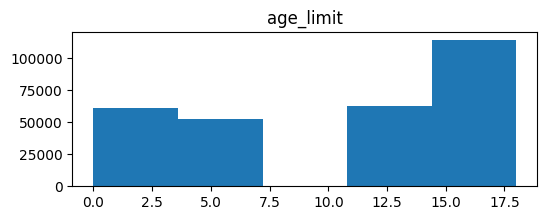

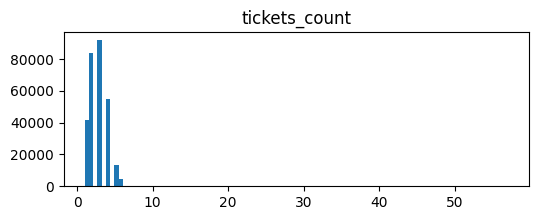

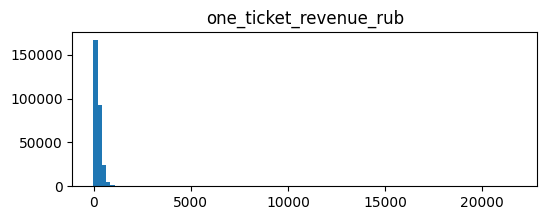

In [13]:
df_full_rub.hist(column=['age_limit'], figsize=(6, 2), bins =5, grid=False)
df_full_rub.hist(column=['tickets_count'], figsize=(6, 2), bins = 100, grid=False)
df_full_rub.hist(column=['one_ticket_revenue_rub'], figsize=(6, 2), bins = 100, grid=False)

Распределение revenue для rub


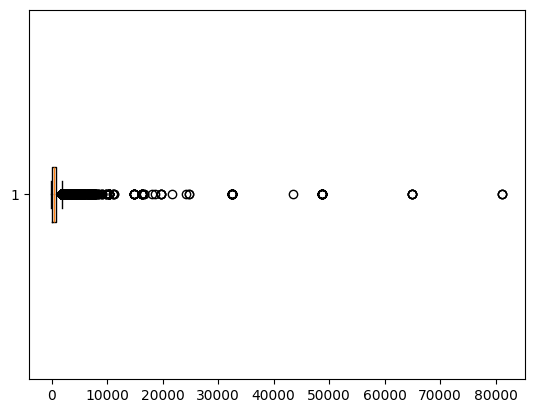

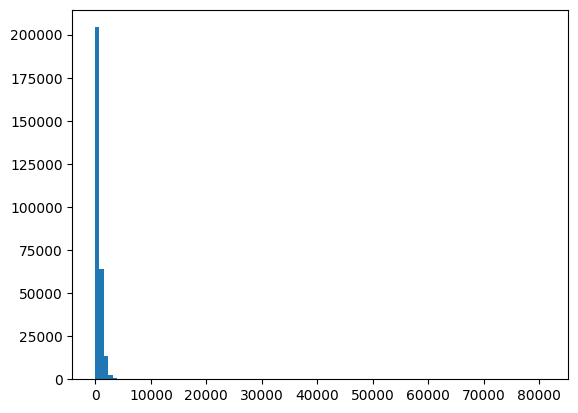

In [14]:
# Разделим датасет и выделим строки для rub
rub = df_full_rub[df_full_rub['currency_code']=='rub']

# Выведем диаграммы для рублей
print('Распределение revenue для rub')
plt.boxplot(rub['revenue'],
            vert=False,
            showfliers=True)
plt.show()

plt.hist(rub['revenue'], bins =100)

plt.show()

Распределение revenue для kzt


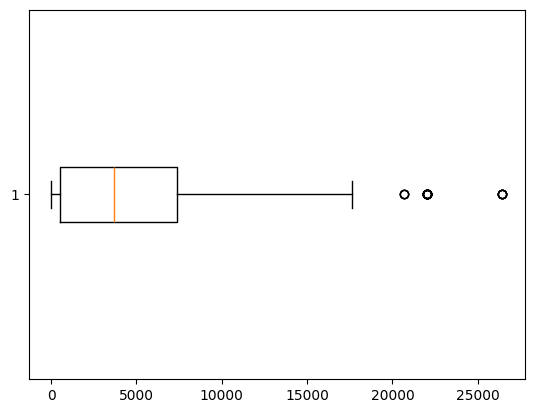

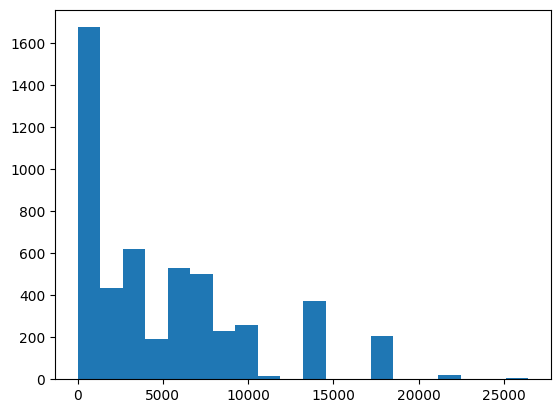

In [15]:
# Разделим датасет и выделим строки для rub
kzt = df_full_rub[df_full_rub['currency_code']=='kzt']

# Выведем диаграммы для рублей
print('Распределение revenue для kzt')
plt.boxplot(kzt['revenue'],
            vert=False,
            showfliers=True)
plt.show()

plt.hist(kzt['revenue'], bins =20)

plt.show()

Наблюдаются выбросы по столбцу `revenue` для валюты `rub` и `kzt` и как следствие по`one_ticket_revenue_rub`.

Для далбнейшего анализа будем использовать датафрейм с очищенными данными (перцинтель 99%)

In [16]:
# Фильтруем данные по столбцу revenue (перцинтель 99%) для каждой валюты по отдельности
rub_f = rub[rub['revenue_rub']<rub['revenue'].quantile(0.99)]
kzt_f = kzt[kzt['revenue_rub']<kzt['revenue'].quantile(0.99)]

# Выведем информацию  по отфильтрованному датафрейму
print('Удалено для rub:\n', len(rub)-len(rub_f), 'строк (', round(100-len(rub_f)/len(rub)*100, 2), '%)')
print()
print('Удалено для kzt:\n', len(kzt)-len(kzt_f), 'строк (', round(100-len(kzt_f)/len(kzt)*100, 2), '%)')

# Объедим два датасета в один
df_filtred = pd.concat([rub_f, kzt_f])
display(df_filtred)
# Выведем статистическую информацию по столбцам
display(df_filtred[['age_limit', 'tickets_count', 'days_since_prev', 'revenue_rub', 'one_ticket_revenue_rub']].describe())

Удалено для rub:
 2857 строк ( 1.0 %)

Удалено для kzt:
 0 строк ( 0.0 %)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.940000,380.485000,8,Лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.450000,144.725000,7,Лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.570000,314.642500,10,Осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.490000,4.245000,7,Лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410000,463.470000,10,Осень
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290484,6862648,ffc24188a1d58f2,2024-07-11,2024-07-11 12:39:48,538828,нет,12,kzt,mobile,4735.52,...,Верхоречная область,Серебрянка,163,4348,"Мастерская живого действия ""Юность"" Лтд","наб. Осенняя, д. 376",865.359449,432.679724,7,Лето
290485,6763294,ffc24188a1d58f2,2024-09-05,2024-09-05 12:07:00,538828,нет,12,kzt,mobile,4735.52,...,Верхоречная область,Серебрянка,163,4348,"Мастерская живого действия ""Юность"" Лтд","наб. Осенняя, д. 376",872.363265,436.181633,9,Осень
290486,3984021,ffc24188a1d58f2,2024-09-06,2024-09-06 19:20:03,533803,нет,16,kzt,mobile,1849.41,...,Шанырский регион,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",343.072949,343.072949,9,Осень
290488,8493869,ffc4133fbba20f4,2024-06-21,2024-06-21 14:04:34,533803,нет,16,kzt,mobile,3698.83,...,Шанырский регион,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",687.209312,343.604656,6,Лето


,age_limit,tickets_count,days_since_prev,revenue_rub,one_ticket_revenue_rub
count,287754.000000,287754.000000,266041.000000,287754.000000,287754.000000
mean,10.197050,2.740223,3.220417,518.688850,190.995219
std,6.526542,1.162685,11.353398,516.052872,168.362791
min,0.000000,1.000000,0.000000,-90.760000,-18.152000
25%,6.000000,2.000000,0.000000,111.802500,45.960000
50%,12.000000,3.000000,0.000000,343.820000,145.905000
75%,16.000000,3.000000,1.000000,788.640000,306.213333
max,18.000000,57.000000,148.000000,5256.843314,2438.270000


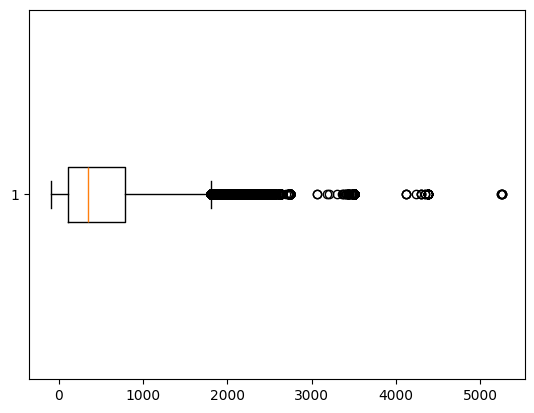

array([[<Axes: title={'center': 'one_ticket_revenue_rub'}>]], dtype=object)

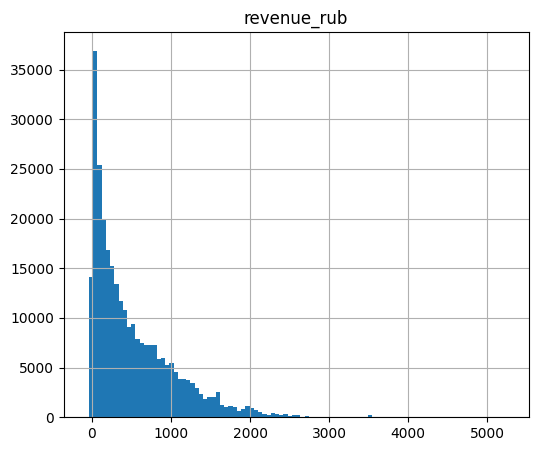

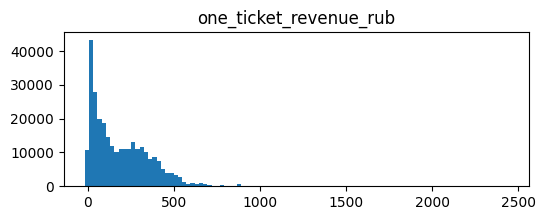

In [17]:

plt.boxplot(df_filtred['revenue_rub'],
            vert=False,
            showfliers=True)
plt.show()

df_filtred.hist(column='revenue_rub', figsize=(6, 5), bins =100)
df_filtred.hist(column=['one_ticket_revenue_rub'], figsize=(6, 2), bins = 100, grid=False)

### Промежуточный результат

## 0.7 Проверка дубликатов

Проверим явные дубликаты без учета столбца `order_id`

In [18]:
# Выводим только дублирующиеся строки
df_drop = df_filtred[df_filtred.iloc[:,1:].duplicated(keep=False)].sort_values(by=['user_id', 'revenue'], ascending=False)
display(df_drop)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
285377,8547983,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,1319.43,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",1319.43,329.857500,6,Лето
285378,8548012,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,1319.43,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",1319.43,329.857500,6,Лето
285385,8547867,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,1319.43,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",1319.43,329.857500,6,Лето
285375,8547809,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,989.57,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",989.57,329.856667,6,Лето
285380,8548041,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,нет,18,rub,desktop,989.57,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",989.57,329.856667,6,Лето
285381,8548070,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,нет,18,rub,desktop,989.57,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",989.57,329.856667,6,Лето
285382,8548099,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,989.57,...,Каменевский регион,Глиногорск,213,4017,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827",989.57,329.856667,6,Лето
259735,588411,e333b28575ed7f9,2024-07-28,2024-07-28 12:50:38,81165,нет,12,rub,mobile,40.84,...,Солнечноземская область,Глинополье,56,3005,"Арт-кафе ""Аксессуар"" Лимитед","бул. Логовой, д. 94 к. 1/5",40.84,40.840000,7,Лето
259736,589252,e333b28575ed7f9,2024-07-28,2024-07-28 12:50:38,81165,нет,12,rub,mobile,40.84,...,Солнечноземская область,Глинополье,56,3005,"Арт-кафе ""Аксессуар"" Лимитед","бул. Логовой, д. 94 к. 1/5",40.84,40.840000,7,Лето
255225,7229817,de88a121becea97,2024-09-21,2024-09-21 17:21:18,571963,нет,6,rub,mobile,1065.84,...,Каменевский регион,Глиногорск,213,4363,"Студия дизайна ""Лестница"" Лимитед","наб. Школьная, д. 9/8 стр. 7/5",1065.84,532.920000,9,Осень


После оценки дубликтов можно сделать вывод что в изначальной БД SQL произошло задвоение некоторых записей

Для дальныйшей работы необходимо удалить эти дубликаты

In [19]:
df_final = df_filtred.drop_duplicates(subset = df_filtred.iloc[:,1:].columns.tolist()).reset_index()
print('Удалено', len(df_filtred)- len(df_final), 'дубликатов')
print('Что составляет', round(100 - len(df_final)/len(df_filtred)*100, 4), '% данных')
print('Размер датафрейма:', len(df_final), 'строк (', round(df_final.memory_usage().sum()/1024/1024,1), 'MB)')

Удалено 30 дубликатов
Что составляет 0.0104 % данных
Размер датафрейма: 287724 строк ( 40.3 MB)


## 0.8 Промежуточные выводы
**Исходные данные:**
> Датафреймы
> - `final_tickets_orders_df.csv`. Кол-во строк 290848 (31.1 MB)
> - `final_tickets_events_df.csv`. Кол-во строк 22426 (1.9 MB)
> - `final_tickets_tenge_df.csv`. Кол-во строк 356 (11.3 MB)

**Пропуски данных**

> Во всех датасетах пропуски данных отсутствуют

**Объединенный датафрейм**

>Объединенный датафрейм имеета размер 290611 строк (64.3 MB)
>
>После преобразования и оптимизации типа данных размер составил 290611 строк (38.5 MB)
>
>Оптимизация составила 38%

**Дополнительные вычисления**
> Расчитаны дополнительные столбцы
> - `revenu_rub` - выручка с заказа в рублях
>- `one_ticket_revenue_rub` - выручка с продажи одного билета на мероприятие в рублях
>- `month` - месяц оформления заказа
>- `season` - столбец с информацией о сезонности

**Очистка данных**
> - Удалены неиспользуемые в дальнейшем столбцы
> - Проверены на аномальные значения все столбцы с количественными значениями
> - Удалены строки с аномальными значениями по столбцу `revenue`
> - Проверены на дубликаты столбцы с категорианальными значениями
> - Удалены явные дубликаты строк
> - Всего удалено данных 2887 строк, что составляет 0.99%

**Итоговый датафрейм**
> Размер итогового датафрейма составил 287724 строк (35.9 MB)

----
# 1. Исследовательский анализ данных

## 1.1 Анализ распределения заказов по сегментам и их сезонные изменения
Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. Изучим изменение пользовательской активности или пользовательского интереса в связи с сезонностью

### 1.1.1 Активность пользователей по месяцам

Рассмотрим количество заказов по месяцам

,month,order_id,Динамика
0,6,34193,NaN
1,7,40405,18.17
2,8,44541,10.24
3,9,69322,55.64
4,10,99263,43.19


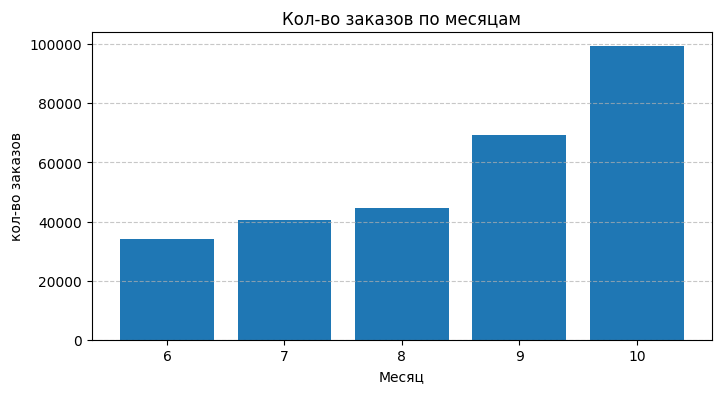

In [20]:
# Группируем данные по месяцам
df_group_month = df_final.groupby('month').agg({'order_id': 'count'}).reset_index()
# Добавим столбец с динамикой от месяца к месяцу
df_group_month['Динамика'] = round(df_group_month['order_id'].pct_change() * 100,2)

# Выводим получившийся результат
display(df_group_month)

#Строим диаграмму распределения
plt.figure(figsize=(8,4))
plt.bar(df_group_month['month'], df_group_month['order_id'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Месяц')
plt.ylabel('кол-во заказов')
plt.title('Кол-во заказов по месяцам')
plt.show()

Наблюдается положительная динамика увеличения кол-ва заказов на протяжении всего рассматриваемого периода

Начианя с сентября наблюдается более значительный прирост пользовательской активности, вероятнее всегосвязанное с окончанием отпусков и изменением погодных условий

### 1.1.2 Распределение по сезонам
Сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу

In [21]:
# Разделим датафрейм на две категории. в зависимости от сезона
df_summer = df_final[df_final['season']=='Лето'].copy()
df_autumn = df_final[df_final['season']=='Осень'].copy()

#### 1.1.2.1 Распределение по типу мероприятий

,Лето,Осень
event_type_main,,
концерты,42.6,37.2
театр,20.1,25.3
другое,27.2,19.7
спорт,2.5,11.2
стендап,5.3,4.1
выставки,2.0,1.4
ёлки,0.2,1.0


<Figure size 800x400 with 0 Axes>

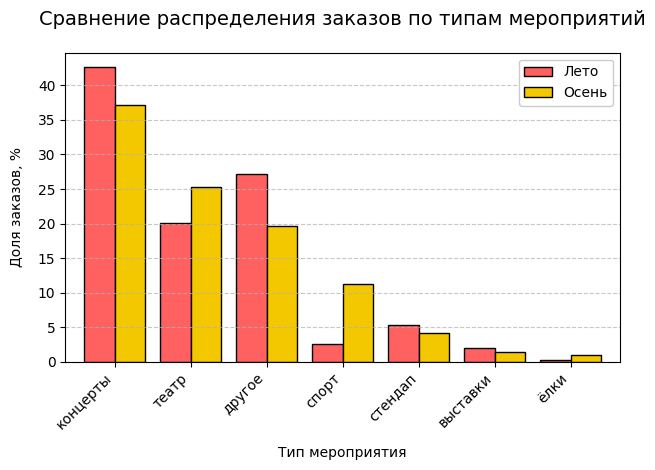

In [22]:
# Считаем доли для каждого сезона по типу мероприятий
event_summer = df_summer['event_type_main'].value_counts(normalize=True).mul(100).round(1)
event_autumn = df_autumn['event_type_main'].value_counts(normalize=True).mul(100).round(1)

# Объединяем в одну таблицу
df_events_season = pd.DataFrame({'Лето': event_summer, 'Осень': event_autumn}).sort_values(by='Осень', ascending=False)
# Показываем результат
display(df_events_season)

#Строим диаграмму
plt.figure(figsize=(8, 4))
df_events_season.plot(kind='bar', width=0.8, color=['#ff6161', '#f4c800'], edgecolor='black')

plt.title('Сравнение распределения заказов по типам мероприятий', pad=20, fontsize=14)
plt.xlabel('Тип мероприятия', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(framealpha=1)
plt.tight_layout()
plt.show()

Из диаграммы можно сделать вывод:
- Летом более популярные категории мероприятий `концерты` (42,6%) и `другое` (27,2%)
- Осень более популярные категории мероприятий `концерты` (37,2%) и `театры` (25,3%)

#### 1.1.2.2 Распределение по типу устройств

,Лето,Осень
device_type_canonical,,
mobile,80.6,79.7
desktop,19.4,20.3


<Figure size 800x400 with 0 Axes>

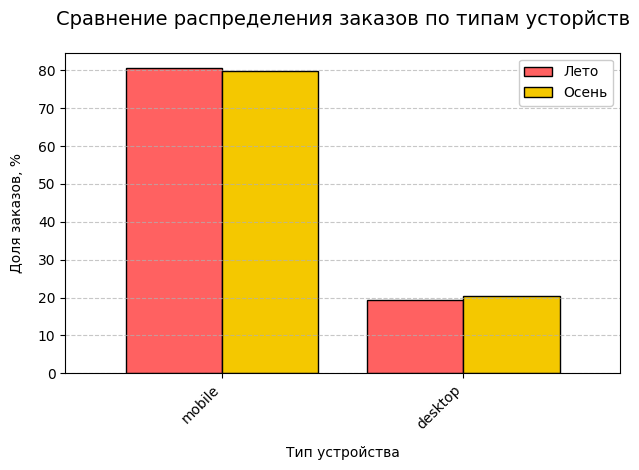

In [23]:
# Считаем доли для каждого сезона по типу устройств
device_summer = df_summer['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)
device_autumn = df_autumn['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)

# Объединяем в одну таблицу
df_device_season = pd.DataFrame({'Лето': device_summer, 'Осень': device_autumn}).sort_values(by='Осень', ascending=False)
# Показываем результат
display(df_device_season)

#Строим диаграмму
plt.figure(figsize=(8, 4))
df_device_season.plot(kind='bar', width=0.8, color=['#ff6161', '#f4c800'], edgecolor='black')

plt.title('Сравнение распределения заказов по типам усторйств', pad=20, fontsize=14)
plt.xlabel('Тип устройства', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(framealpha=1)
plt.tight_layout()
plt.show()

Сезонность не влият на выбор устройства.

`80%` пользователей выбирают мобильные устройства

#### 1.1.2.3 Распределение по возрастному рейтингу

,Лето,Осень
age_limit,,
16,28.3,26.2
0,18.0,23.6
12,20.5,22.1
6,18.2,17.6
18,15.0,10.4


<Figure size 800x400 with 0 Axes>

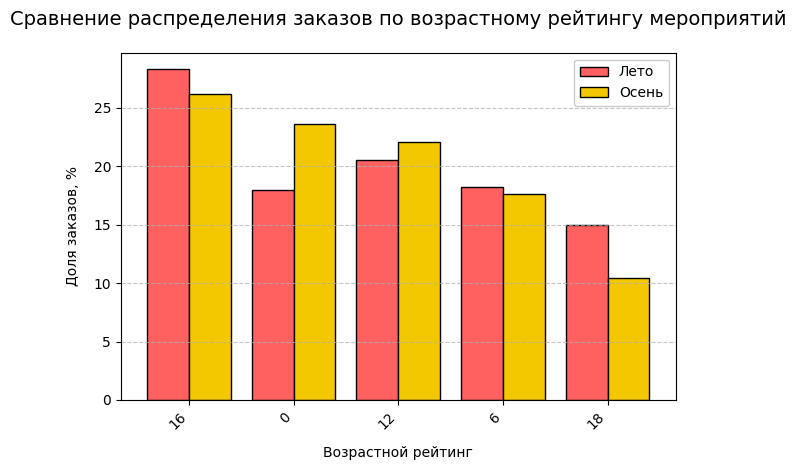

In [24]:
# Считаем доли для каждого сезона по возрастному рейтингу мероприятий
age_summer = df_summer['age_limit'].value_counts(normalize=True).mul(100).round(1)
age_autumn = df_autumn['age_limit'].value_counts(normalize=True).mul(100).round(1)

# Объединяем в одну таблицу
df_age_season = pd.DataFrame({'Лето': age_summer, 'Осень': age_autumn}).sort_values(by='Осень', ascending=False)
# Показываем результат
display(df_age_season)

#Строим диаграмму
plt.figure(figsize=(8, 4))
df_age_season.plot(kind='bar', width=0.8, color=['#ff6161', '#f4c800'], edgecolor='black')

plt.title('Сравнение распределения заказов по возрастному рейтингу мероприятий', pad=20, fontsize=14)
plt.xlabel('Возрастной рейтинг', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(framealpha=1)
plt.tight_layout()
plt.show()

- Семейный сегмент (0+) увеличивает активность осенью на 5.6% (с 18.0% до 23.6%)
    - Это иожет быть связано с окончанием теплого сезона, что вынуждает пользователей больше находиться вне открытого воздуха
- Подростки (12+) увеличивает активность осенью на 1.6% (с 20.5% до 22.1%)
    - Такое изменение можно считать незначительным
- Молодежная аудитория (16+ и 18+) сокращает активность осенью суммарно на 6.4% (с 43.1% до 36.7%)
    - Снижение активности связано с окончанием отпускного периода, вследствие чего отсутствие времени на проведение досуга
- Аудитория школьного возраста (6+) осенью сокращается на 0.6% (с 18.2% до 17.6%)
    - Такое изменение можно считать незначительным


### 1.1.3 Изменение выручки с продажи одного билета 

season,Лето,Осень,change
event_type_main,,,
стендап,218.518107,231.124973,5.769255
выставки,86.416198,90.603610,4.845634
спорт,50.761831,49.969733,-1.560421
другое,77.433968,76.115334,-1.702914
концерты,305.030172,268.084074,-12.112277
ёлки,271.436176,229.585589,-15.418205
театр,214.138855,175.969508,-17.824578


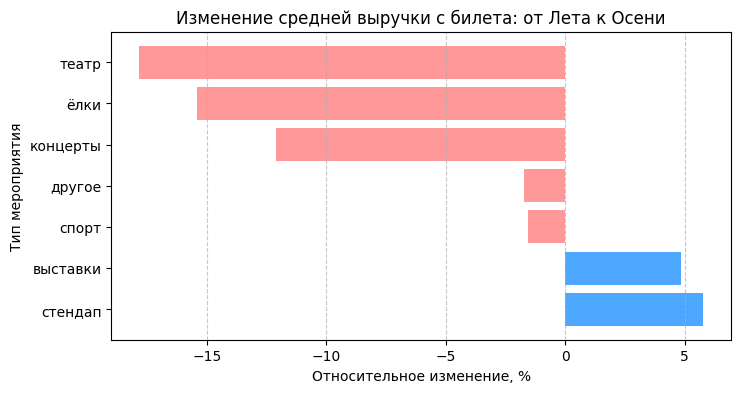

In [25]:
# Расчитаем среднюю выручку по категориям и сезонам
revenue_mean = df_final.groupby(['event_type_main', 'season'], observed=False)['one_ticket_revenue_rub'].agg('mean').unstack()

# Добавляем новую категорию в индекс столбцов
revenue_mean.columns = revenue_mean.columns.set_categories(list(revenue_mean.columns) + ['change'])

# Расчитываем изменение выручки от Лета к Осени
revenue_mean['change'] = (revenue_mean['Осень'] / revenue_mean['Лето'] -1)*100
revenue_mean = revenue_mean.sort_values(by='change', ascending = False)

# Выводим результат
display(revenue_mean)

# Строим визуализацию
plt.figure(figsize=(8, 4))
plt.barh(revenue_mean.index, revenue_mean['change'], 
                color=np.where(revenue_mean['change'] > 0, '#4da6ff', '#ff9999'))

plt.title('Изменение средней выручки с билета: от Лета к Осени')
plt.xlabel('Относительное изменение, %')
plt.ylabel('Тип мероприятия')
plt.grid(axis='x', linestyle='--', alpha=0.7)

- Стендапы и выставки показывают увеличение выручки. Выставки: 86 руб. → 91 руб. (+5%). Стндапы: 219 руб. → 231 руб. (+6%)
    - Возможная причина: осенью закрытые площадки более востребованы для проведения мероприятий, что приводит к увеличению аренды и стоимости билета
- Спорт и концерты показывают снижение выручки. Спорт: 51 руб. → 50 руб. (-2%). Концерты: 305 руб. → 268 руб. (-12%)
    - Возможная причина: увеличение кол-ва меропирятий в осений период и как следствие снижение стоимости билета
- Театр и ёлки также дешевеют осенью: Театр: 214 руб. → 176 руб. (-18%). Ёлки: 271 руб. → 230 руб. (-15%)
    - Возможная причина: осенью преобладают локальные постановки, а не премьеры.

### 1.1.4 Промежуточный вывод
1. На всем рассматриваемом периоде наблюдается прирост количества заказов, с увеличением скорости прироста в осенний период
2. Набилее популярными мероприятия являются концерты (~ 40%), театры (~ 22%) и другое (~22%)
3. Больше всего пользователи используют мобильные устройства (~80%)
4. Мероприятия с рейтингом 0+ и 12+ в осенний период стали чаще пользоваться популярностью у пользователей.
5. В осенний период средняя выручка с одного билета для большинства типов мероприятий снизилась

## 1.2 Осенняя активность пользователей

#### 1.2.1 Анализ дневной активности в осенний период

In [26]:
# Группируем данные по дням в осеннем периоде
daily_stats = df_autumn.groupby('created_dt_msk').agg(
              total_orders=('order_id', 'count'), # общее число заказов
              unique_users=('user_id', 'nunique'),
              revenue=('revenue_rub', 'sum')).reset_index() # общее количество пользователей

# Рассчитываем кол-во заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['unique_users']
daily_stats['avg_ticket_price'] = daily_stats['revenue'] / daily_stats['total_orders']

print(round(daily_stats[['total_orders', 'unique_users', 'avg_ticket_price']].describe(),1))


pd.set_option('display.max_rows', 100)

display(daily_stats[['created_dt_msk', 'total_orders', 'unique_users', 'orders_per_user', 'avg_ticket_price']])

       total_orders  unique_users  avg_ticket_price
count          61.0          61.0              61.0
mean         2763.7         923.4             498.4
std           967.9         143.4              59.6
min          1327.0         564.0             225.2
25%          2313.0         822.0             483.7
50%          2649.0         946.0             509.8
75%          2910.0        1025.0             530.9
max          7288.0        1272.0             573.6


,created_dt_msk,total_orders,unique_users,orders_per_user,avg_ticket_price
0,2024-09-01,1327,564,2.352837,547.253889
1,2024-09-02,1380,574,2.404181,509.810409
2,2024-09-03,5111,778,6.569409,225.240536
3,2024-09-04,1772,685,2.586861,483.685673
4,2024-09-05,1944,739,2.630582,508.957497
5,2024-09-06,2124,864,2.458333,475.787138
6,2024-09-07,1958,794,2.465995,521.631201
7,2024-09-08,1713,717,2.389121,487.758180
8,2024-09-09,2093,778,2.690231,423.505885
9,2024-09-10,2020,762,2.650919,484.539002


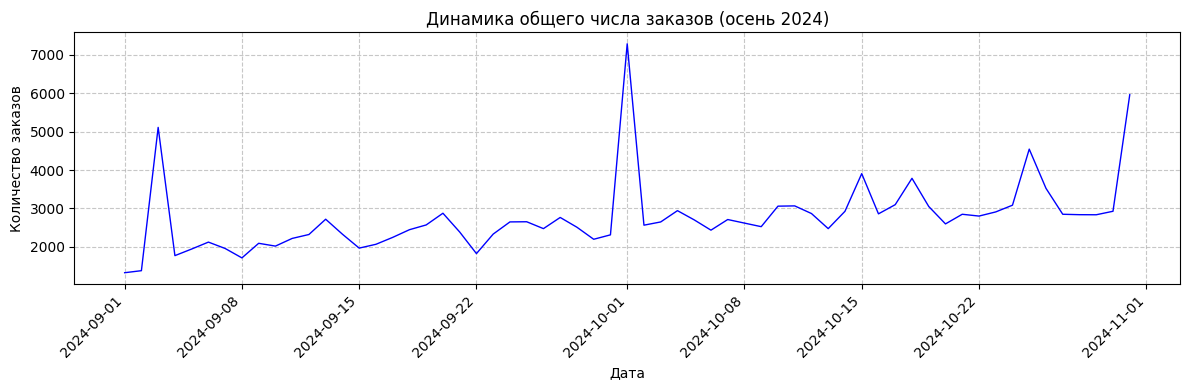

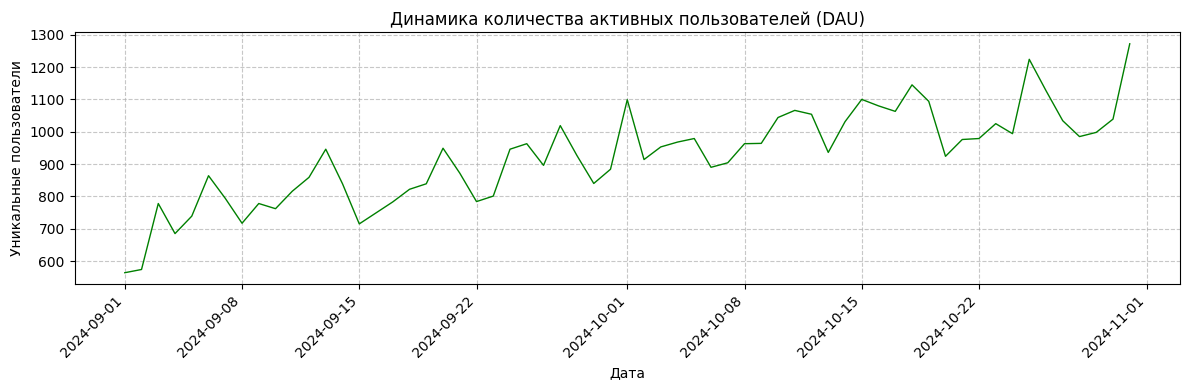

In [27]:
# Строим линейный график динамики общего числа заказов по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['created_dt_msk'], daily_stats['total_orders'], color='blue', linestyle='-', linewidth=1)
plt.title('Динамика общего числа заказов (осень 2024)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Строим линейный график динамики количества активных пользователей по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['created_dt_msk'], daily_stats['unique_users'], color='green', linestyle='-', linewidth=1)
plt.title('Динамика количества активных пользователей (DAU)')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи')
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Заказы:
- Среднедневной уровень заказов: 2784.
- Пики: 3 сентября (5120 заказов) - вероятно, массовые покупки (корпоративные заказы или крупное мероприятие), 30 сентября (7309 - максимум) - возможно, начало акций, 31 октября (5988) - (хэллоуинский всплеск), 25 октября – 4582 заказов (локальный пик). 
- Спады: 4, 31 сентября – 1780, 2584 заказов соответственно (резкий спад после аномалии 3 сентября).

Пользователи:
- Среднедневной уровень пользователей: 928.
- Пики: 31 октября – 1281 DAU (максимум, хэллоуинские активности), 25 октября – 1226 DAU (второй пик, возможно, концерты или фестивали), 30 сентября – 1105 DAU (аномально высокий показатель для сентября, в совокупности с кол-вом заказа можно точно сказать что была акция).
- Спады: 1–2 сентября – ~573 DAU (низкая активность в начале месяца, праздник 1 сентября), 22 сентября – 787 DAU (спад в выходные).

Общий тренд на рост метрик.

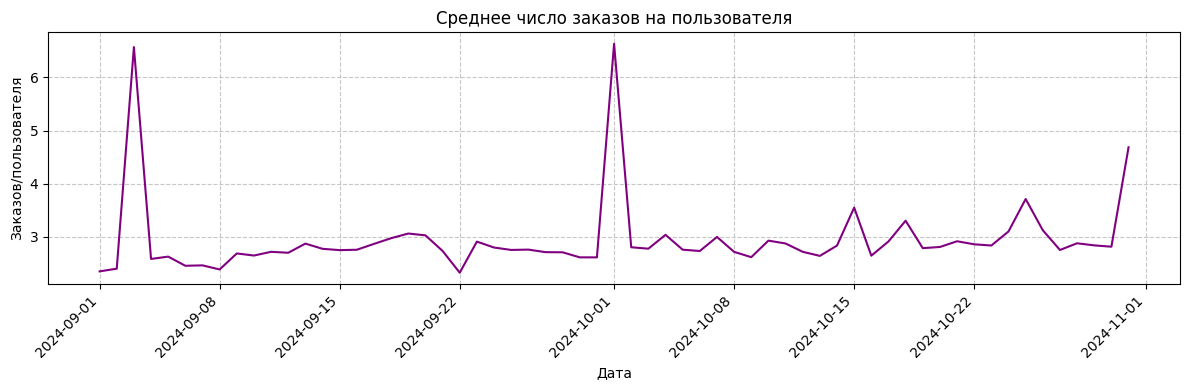

In [28]:
# Строим линейный график динамики среднего количества заказов на пользователя по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['created_dt_msk'], daily_stats['orders_per_user'], color='purple', linestyle='-')
plt.title('Среднее число заказов на пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователя')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Типичные значения колеблются между 2.3 и 3.1, что указывает на стандартное поведение пользователей (1 пользователь делает 2-3 заказа).

Пики:

- Аномально высокие значения: 3 сентября (6.55) и 30 сентября (6.62) - экстремальные всплески, возможно, это групповые покупки, корпоративные заказы. Особенно показательно для 30 сентября - рекордное значение при 884 пользователях.
- 31 октября (4.67) - повышенный спрос, связанный с хэллоуинскими мероприятиями.
- 25 октября (3.74), 15 октября (3.55), 18 октября (3.31) - периоды повышенной активности, возможно связанные с популярными событиями.

Спады:

- 22 сентября (2.34) - самый низкий показатель, возможно слабая активность в выходной день.

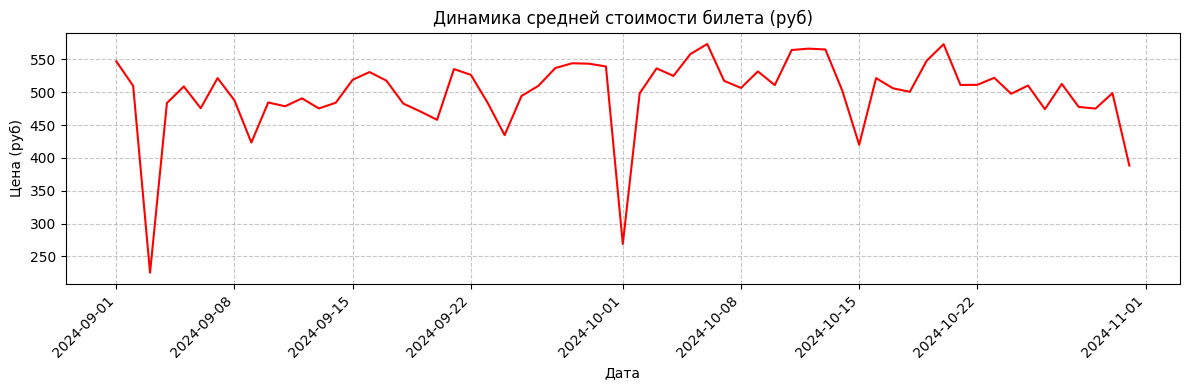

In [29]:
# Строим линейный график динамики средней стоимости билета по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['created_dt_msk'], daily_stats['avg_ticket_price'], color='red', linestyle='-')
plt.title('Динамика средней стоимости билета (руб)')
plt.xlabel('Дата')
plt.ylabel('Цена (руб)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Типичный разброс: 450–600 руб.
- Выше среднего: 500–600 руб. (большинство дней)
- Ниже среднего: <500 руб. (аномально дешевые дни)
    
Самые низкие цены:
- 3 сентября (230 руб.) – рекордно низкая стоимость (совпадает с пиком заказов – 5120).
- 31 октября (400 руб.) – несмотря на хэллоуин, цена ниже среднего.

Самые высокие цены:
- 20 октября (592 руб.) – максимальная стоимость.
- 5 сентября (526 руб.) – резкий рост после дешевого 3 сентября.

#### 1.2.2 Анализ недельной активности в осенний период

In [30]:
# Добавляем день недели (1=Пн, 7=Вс)
df_autumn['day_of_week'] = df_autumn['created_dt_msk'].dt.dayofweek  # 1-7
df_autumn['day_name'] = df_autumn['created_dt_msk'].dt.day_name()  
# Метка выходных
df_autumn['is_weekend'] = df_autumn['created_dt_msk'].isin([5, 6])  # 5=Сб, 6=Вс

In [31]:
# Группировка по дням недели
weekday_stats = df_autumn.groupby(['day_name', 'is_weekend']).agg(
                total_orders=('order_id', 'count'),
                unique_users=('user_id', 'nunique'),
                total_revenue=('revenue_rub', 'sum')).reset_index()

weekday_stats['total_revenue'] = weekday_stats['total_revenue'].round(2)

# Сортировка по дням недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['day_name'] = pd.Categorical(weekday_stats['day_name'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('day_name')

# Расчёт метрик
weekday_stats['avg_orders_per_user'] = weekday_stats['total_orders'] / weekday_stats['unique_users'] 
weekday_stats['avg_revenue_per_user'] = weekday_stats['total_revenue'] / weekday_stats['unique_users']

# Настраиваем отображение чисел
pd.set_option('display.float_format', '{:,.2f}'.format)
display(weekday_stats)

,day_name,is_weekend,total_orders,unique_users,total_revenue,avg_orders_per_user,avg_revenue_per_user
1,Monday,False,21511,4445,"10,749,434.75",4.84,"2,418.32"
5,Tuesday,False,31480,4793,"12,155,526.31",6.57,"2,536.10"
6,Wednesday,False,22881,4812,"11,506,858.64",4.75,"2,391.28"
4,Thursday,False,27166,4970,"13,006,428.35",5.47,"2,616.99"
0,Friday,False,24826,4870,"12,597,553.36",5.10,"2,586.77"
2,Saturday,False,21333,4571,"11,272,028.12",4.67,"2,465.99"
3,Sunday,False,19388,4394,"10,485,404.04",4.41,"2,386.30"


Рабочие дни (Пн–Пт):
- Выше средние показатели по заказам, выручке и пользователям.

- Пиковые дни:
    - Вторник – максимальные заказы (31480).
    - Четверг – наибольшее число уникальных пользователей (5.47) и выручка (13.0 млн руб).
Возможно, связаны с анонсами мероприятий, корпоративными заказами или акциями.

Выходные (Сб–Вс):
- Снижение активности на 10–15% по сравнению с рабочими днями.
- Воскресенье – минимум по всем метрикам (19388 заказов, 4394 пользователей).
Возможно, меньше деловых/групповых покупок, пользователи чаще отдыхают.

### 1.2.3 Промежуточный вывод
1. В осенний период наблюдается положительный рост динамики числа заказов и динамики активных пользователей
2. Среднее число заказов на одного пользователя и средняя стоимость билета практически не изменяется
3. Рабочие дни по всем показателям выше чем выходные дни

## 1.3 Популярные события и партнёры

#### 1.3.1 Анализ регионов
Рассмотрим для каждого региона уникальное количество мероприятий и общее число заказов.

In [32]:
# Группируем данные по регионам
region_stats = df_final.groupby('region_name').agg(
               region_events=('event_id', 'nunique'),  # Уникальные мероприятия
               region_orders=('order_id', 'count'),     # Общее число заказов
               region_unique_users=('user_id', 'nunique')).reset_index() # Уникальные пользователи

# Сортируем по количеству уникальных мероприятий (по убыванию)
region_stats = region_stats.sort_values('region_events', ascending=False)

pd.set_option('display.max_rows', 20)
display(region_stats)

,region_name,region_events,region_orders,region_unique_users
23,Каменевский регион,5935,89665,10550
60,Североярская область,3800,43739,6692
77,Широковская область,1232,16169,3250
57,Светополянский округ,1075,7502,1659
52,Речиновская область,702,6267,1528
...,...,...,...,...
5,Верхозёрский край,2,11,5
33,Лесноярский край,2,19,10
56,Светолесский край,2,24,15
66,Сосноводолинская область,2,10,7


In [33]:
# ТОП-7 регионов по разнообразию событий
top_7 = region_stats.sort_values('region_events', ascending=False).head(7)

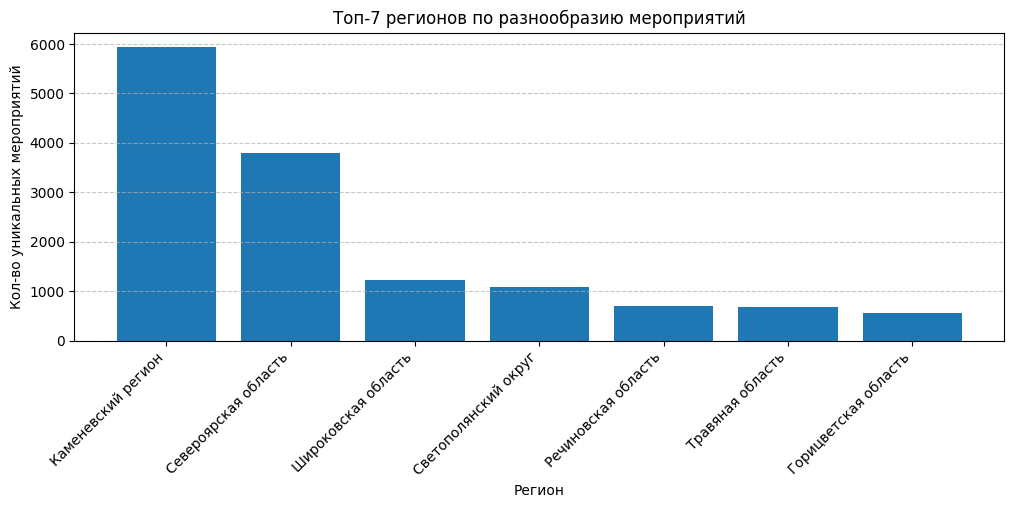

In [34]:
#Строим диаграмму 
plt.figure(figsize=(12,4))
plt.bar(top_7['region_name'], top_7['region_events'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Регион')
plt.ylabel('Кол-во уникальных мероприятий')
plt.title('Топ-7 регионов по разнообразию мероприятий')
plt.show()

In [35]:
# Расчитаем для каждого региона долю мероприятий от их общего числа и долю заказов в регионе от общего числа заказов.
# Общее количество мероприятий и заказов
total_events = df_final['event_id'].nunique()
total_orders = df_final['order_id'].count()
total_revenue = df_final['revenue_rub'].sum()

# Расчитываем доли
region_stats['events_share'] = (region_stats['region_events'] / total_events * 100).round(2)
region_stats['orders_share'] = (region_stats['region_orders'] / total_orders * 100).round(2)

In [36]:
top_7_regions_events = region_stats.sort_values('events_share', ascending=False).head(7)
display(top_7_regions_events[['region_name', 'events_share', 'orders_share']])

,region_name,events_share,orders_share
23,Каменевский регион,26.54,31.16
60,Североярская область,17.00,15.20
77,Широковская область,5.51,5.62
57,Светополянский округ,4.81,2.61
52,Речиновская область,3.14,2.18
74,Травяная область,3.05,1.75
11,Горицветская область,2.46,1.79


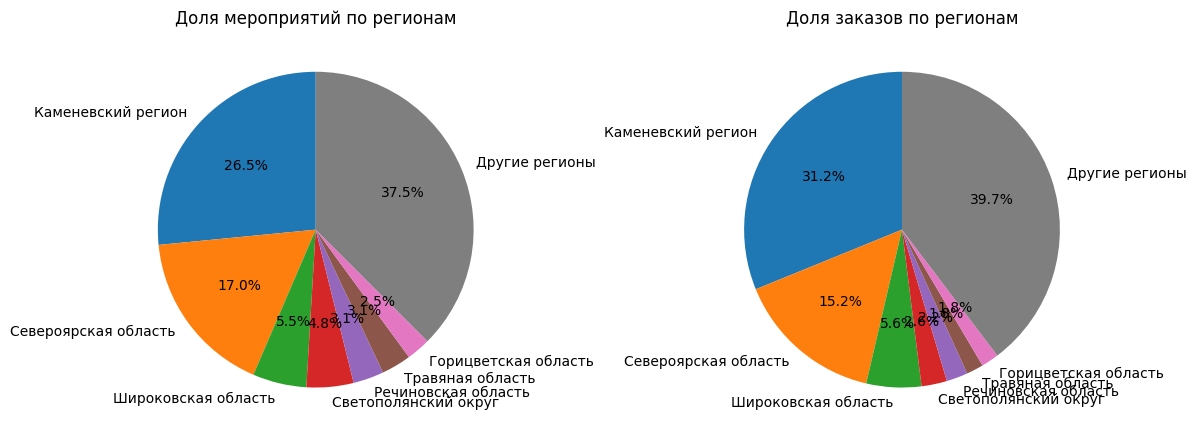

In [37]:
# Визуализируем относительные значения 
# Создаем строку "Другие регионы"
other_events = total_events - top_7_regions_events['region_events'].sum()
other_orders = total_orders - top_7_regions_events['region_orders'].sum()

top_7_with_other = pd.concat([top_7_regions_events, 
                             pd.DataFrame({
                                'region_name': ['Другие регионы'],
                                'events_share': [(other_events / total_events * 100)],
                                'orders_share': [(other_orders / total_orders * 100)]}
                                         )], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Доля мероприятий с другими регионами
ax1.pie(top_7_with_other['events_share'],
        labels=top_7_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Доля мероприятий по регионам')

# Доля заказов с другими регионами
ax2.pie(top_7_with_other['orders_share'],
        labels=top_7_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90)
ax2.set_title('Доля заказов по регионам')

plt.tight_layout()
plt.show()

- Каменевский регион — лидер, генерирующий 31% заказов при 27% событий, что указывает на востребованность мероприятий.
- Североярская область показывает сбалансированные показатели
- Светополянский округ и Речиновская область отстают по заказам (в 2 раза ниже доли событий), что требует анализа цен, инфраструктуры или маркетинга

#### 1.3.1 Анализ партнеров
Рассмотрим для каждого билетного партнёра общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

,Партнер,Кол-во уникальных событий,Кол-во заказов,Выручка,Доля событий %,Доля заказов %,Доля выручки %
3,Билеты без проблем,4247,62832,"24,255,351.59",18.99,21.84,16.25
24,Мой билет,1300,34469,"22,172,487.68",5.81,11.98,14.86
25,Облачко,2335,26402,"18,588,613.86",10.44,9.18,12.46
21,Лови билет!,4867,40800,"16,670,333.48",21.77,14.18,11.17
8,Весь в билетах,855,16410,"16,494,669.19",3.82,5.70,11.05
5,Билеты в руки,3530,40281,"13,194,329.82",15.79,14.00,8.84
19,Край билетов,252,6109,"6,405,689.22",1.13,2.12,4.29


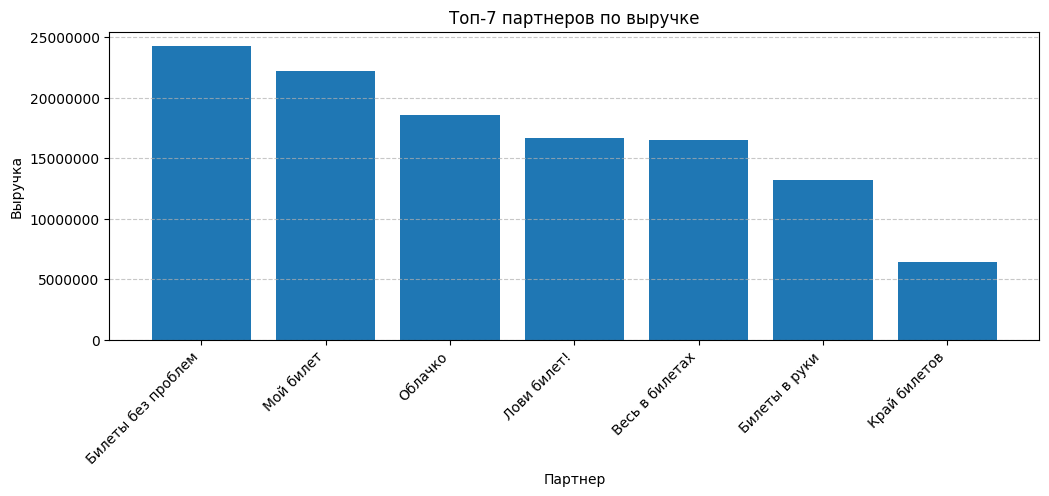

In [38]:
# Группируем данные по партнёрам
partner_stats = df_final.groupby('service_name').agg(
                partner_events=('event_id', 'nunique'),  # Уникальные мероприятия
                partner_orders=('order_id', 'count'),     # Общее число заказов
                partner_revenue=('revenue_rub', 'sum')).reset_index()    # Суммарная выручка

# Расчитываем дополнительные столбцы
partner_stats['Доля событий %'] = partner_stats['partner_events'] / total_events*100
partner_stats['Доля заказов %'] = partner_stats['partner_orders'] / total_orders*100
partner_stats['Доля выручки %'] = partner_stats['partner_revenue'] / total_revenue*100
# Переименуем столбцы
partner_stats = partner_stats.rename(columns={'service_name': 'Партнер',
                                              'partner_events': 'Кол-во уникальных событий',
                                              'partner_orders': 'Кол-во заказов',
                                              'partner_revenue' : 'Выручка'})

#Выделим Топ-7 по выручке
partner_top_7_revenue = partner_stats.sort_values('Выручка', ascending=False).head(7).copy()

display(partner_top_7_revenue)

#Строим диаграмму 
plt.figure(figsize=(12,4))
plt.bar(partner_top_7_revenue['Партнер'], partner_top_7_revenue['Выручка'])
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Партнер')
plt.ylabel('Выручка')
plt.title('Топ-7 партнеров по выручке')
plt.show()

,Партнер,Кол-во уникальных событий,Кол-во заказов,Выручка,Доля событий %,Доля заказов %,Доля выручки %
21,Лови билет!,4867,40800,"16,670,333.48",21.77,14.18,11.17
3,Билеты без проблем,4247,62832,"24,255,351.59",18.99,21.84,16.25
5,Билеты в руки,3530,40281,"13,194,329.82",15.79,14.00,8.84
25,Облачко,2335,26402,"18,588,613.86",10.44,9.18,12.46
22,Лучшие билеты,1762,17741,"2,724,060.58",7.88,6.17,1.83
24,Мой билет,1300,34469,"22,172,487.68",5.81,11.98,14.86
30,Тебе билет!,1062,5177,"2,928,882.72",4.75,1.80,1.96


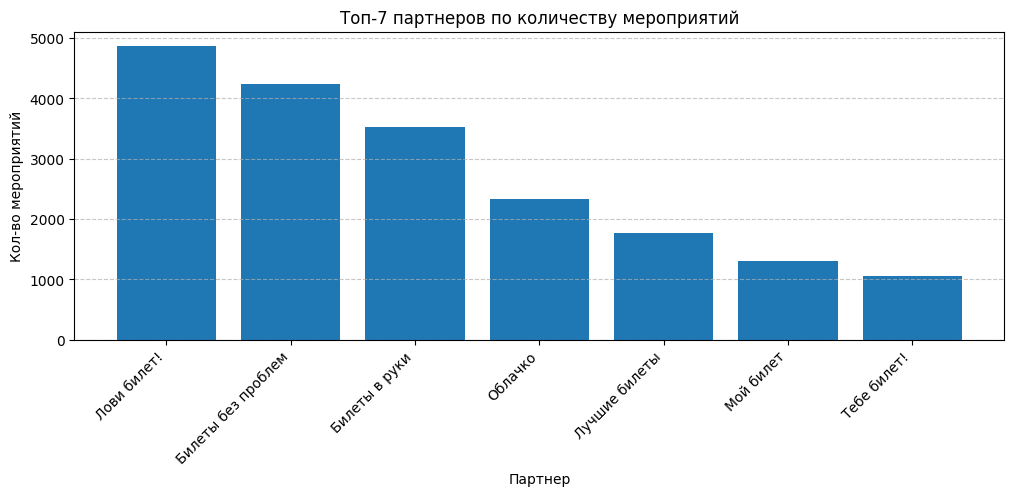

In [39]:
#Выделим Топ-7 по выручке
partner_top_7_event = partner_stats.sort_values('Кол-во уникальных событий', ascending=False).head(7).copy()

display(partner_top_7_event)

#Строим диаграмму 
plt.figure(figsize=(12,4))
plt.bar(partner_top_7_event['Партнер'], partner_top_7_event['Кол-во уникальных событий'])
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Партнер')
plt.ylabel('Кол-во мероприятий')
plt.title('Топ-7 партнеров по количеству мероприятий')
plt.show()

"Билеты без проблем", "Облачко" и "Лови билет!"  входят в Топ-5 как по выручке так и по кол-ву мероприятий, что свидетельствует о высокой эффективности построенной бизнес модели

Лидеры по охвату:

- "Лови билет!" лидирует по числу уникальных событий (21.8%), но занимает лишь 4-е место по выручке (11.2%).

- "Билеты без проблем" — второй по событиям (19%), но главный по выручке (16.2%) и заказам (21.8%).

Эффективность монетизации:

- "Мой билет" при относительно скромном охвате (5.8% событий) генерирует 14.9% выручки — лучшая конверсия в деньгах.

- "Лучшие билеты" (7.9% событий → 1.8% выручки) — наименее эффективны.

### 1.3.3 Промежуточный вывод
1. Каменевский регион является самым лидер относительно других по ключевым метрикам
2. Лидерами среди партнеров по совокупности метрик являются:
    - "Билеты без проблем"
    - "Облачко"
    - "Лови билет!"
3. Эффективность монетизации
    - Лидер: "Мой билет"
    - Антилидер "Лучшие билеты"

----
# 2. Статистический анализ данных

## 2.1 Проверка гипотезы о среднем количестве заказов в зависимости от типа устройства

**Гипотеза №1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.**

Формулировка гипотез:
- Нулевая гипотеза (H₀): Среднее количество заказов на одного пользователя мобильного приложения не выше среднего количества заказов на одного пользователя стационарных устройств.

      μ_mobile = μ_desktop

- Альтернативная гипотеза (H₁): Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

      μ_mobile > μ_desktop

,mobile,desktop
count,"19,709.00","7,086.00"
mean,11.69,8.10
std,100.83,48.26
min,1.00,1.00
25%,1.00,1.00
50%,2.00,2.00
75%,5.00,4.00
max,"7,691.00","2,487.00"


C:\Users\DernovoiPV\AppData\Local\Temp\ipykernel_12248\3086332340.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data,


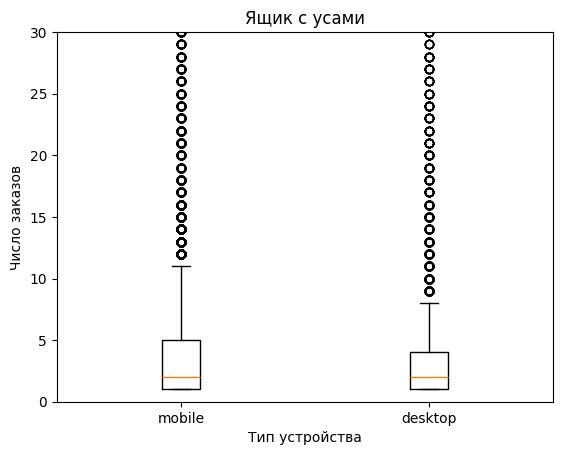

In [40]:
# Группируем по пользователям и считаем заказы:
df_user_orders = df_final.groupby(['user_id', 'device_type_canonical'], observed=True).agg(orders=('order_id', 'count')).reset_index()



# Выделяем группы по типу устройств
mobile_order = df_user_orders[df_user_orders['device_type_canonical']=='mobile']['orders']
desktop_order = df_user_orders[df_user_orders['device_type_canonical']=='desktop']['orders']

display(pd.DataFrame({'mobile': mobile_order.describe(), 'desktop': desktop_order.describe()}))

# Строим диаграмму BoxPlot
all_data = [mobile_order, desktop_order]
labels=['mobile', 'desktop']
plt.boxplot(all_data,
            labels=labels,
            vert=True,
            showfliers=True)
plt.ylim(0, 30)
plt.title('Ящик с усами')
plt.ylabel('Число заказов')
plt.xlabel('Тип устройства')
plt.show()

В исходных данных наблюдаются аномалии:
- Большое количество выбросов (при стандартном отклонении = 101 и 48, макс = 7691 и 2 487 соответственно для mobile и desktop)
- Высокое отклонение среднего от стандартного отклонения (при среднем = 11.7 и 8.1, стандартное отклонение = 101 и 48 соответственно для mobile и desktop). Тоесть надлюдается правосторонее распредление данных с длинными хвостами справа (что наблюдается на диаграмме)
- размер группы mobile (19709 пользователей) больше в 2.8 раза размера группы desktop (7086)

Так как распреджеленеи данных асимметричное, для проверки гипотезы применим тест Манна-Уитни

Предварительно подготовим данные для проведения теста:
- разделим всех пользователей на группы по типу устройства
- удалим пользователей входящих в обе группы
- с получившимися группами прведен тест Манна-Утни

In [41]:
# Разделим датафрем на две группы по типу устройств
mobile_users = df_user_orders[df_user_orders['device_type_canonical'] == 'mobile']
desktop_users = df_user_orders[df_user_orders['device_type_canonical'] == 'desktop']

In [42]:
# Выделим уникальных пользователей в каждой группе
mobile_ids = set(mobile_users['user_id'])
desktop_ids = set(desktop_users['user_id'])

# проверим пересечение пользователей между группами
common_users = mobile_ids & desktop_ids

# Выводим информацию по пользователям
print(f'Группа mobile: Всего пользователей {len(mobile_ids)}. Уникальных для этой группы пользователей {len(mobile_ids)-len(common_users)}')
print(f'Группа desktop: Всего пользователей {len(desktop_ids)}. Уникальных для этой группы пользователей {len(desktop_ids)-len(common_users)}')

Группа mobile: Всего пользователей 19709. Уникальных для этой группы пользователей 14755
Группа desktop: Всего пользователей 7086. Уникальных для этой группы пользователей 2132


In [43]:
# Удалим из групп сравнения пересекающихся пользователей
mobile_order_uniq = df_user_orders[~df_user_orders['user_id'].isin(common_users)]['orders']
desktop_order_uniq = df_user_orders[~df_user_orders['user_id'].isin(common_users)]['orders']

In [44]:
# Проводимтест Манна-Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(mobile_order_uniq, 
                            desktop_order_uniq,
                            alternative='greater')  # Правосторонняя проверка
print(f'p-значение: {p_value:.10f}') 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше")
else:
    print("Подтверждаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше")

p-значение: 0.5000002386
Подтверждаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше


**`Среднее количество заказов на одного пользователя мобильного приложения (11.69) выше среднего количества заказов на одного пользователя стационарных устройств (8.10).`**

Это утверждение статистически значимо.

## 2.2 Проверка гипотезы о среднем времени между заказами в зависимости от типа устройства

**Гипотеза №2: реднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.**

Формулировка гипотез:
- Нулевая гипотеза (H₀): Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств.

      μ_mobile = μ_desktop

- Альтернативная гипотеза (H₁): Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

      μ_mobile > μ_desktop

In [45]:
# Удаляем строки, где days_since_prev = "нет" (преобразуем их в NaN)
df_mean_time = df_final.copy()
df_mean_time['days_since_prev'] = pd.to_numeric(df_mean_time['days_since_prev'], errors='coerce')

# Удаляем оставшиеся пропуски (первые заказы пользователей)
df_mean_time = df_mean_time.dropna(subset=['days_since_prev'])

# Проверяем результат
print(f"В изначальном датасете {len(df_final)} строк")
print(f"В обработанном датасете {len(df_mean_time)} строк")
print(f"Удалено {round((1-len(df_mean_time)/len(df_final))*100,2)} % данных")

В изначальном датасете 287724 строк
В обработанном датасете 266011 строк
Удалено 7.55 % данных


,mobile,desktop
count,"212,377.00","53,634.00"
mean,3.33,2.79
std,11.53,10.61
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,1.00,1.00
max,148.00,146.00


C:\Users\DernovoiPV\AppData\Local\Temp\ipykernel_12248\1406287959.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data,


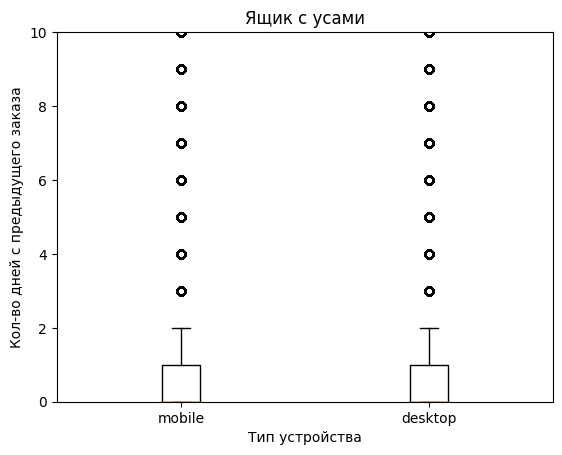

In [46]:
# Выделяем группы по типу устройств
# Сразу отфильтруем пользователей (оставим только тех, у кого между заказами кол-во дней > 0)
mobile_days =df_mean_time[df_mean_time['device_type_canonical']=='mobile']['days_since_prev']
desktop_days = df_mean_time[df_mean_time['device_type_canonical']=='desktop']['days_since_prev']

# Рассмотри статистические показатели по обоим группам
display(pd.DataFrame({'mobile': mobile_days, 'desktop': desktop_days}).describe())

# Строим диаграмму BoxPlot
all_data = [mobile_days, desktop_days]
labels=['mobile', 'desktop']
plt.boxplot(all_data,
            labels=labels,
            vert=True,
            showfliers=True)
plt.ylim(0, 10)
plt.title('Ящик с усами')
plt.ylabel('Кол-во дней с предыдущего заказа')
plt.xlabel('Тип устройства')
plt.show()

В исходных данных наблюдаются аномалии:
- Присутствуют выбросы (при стандартном отклонении = 11.5 и 10.6, макс = 148 и 146 соответственно для mobile и desktop)
- Отклонение среднего от стандартного отклонения (при среднем = 3.3 и 2.8, стандартное отклонение = 11.5 и 10.6 соответственно для mobile и desktop). Тоесть надлюдается правосторонее распредление данных хвостами справа (что наблюдается на диаграмме)
- У обоих групп медианное значение и минамальное = 0 дней, Следовательно большая часть заказов соверщается в течение одного дня.

Так как распреджеленеи данных асимметричное, для проверки гипотезы применим тест Манна-Уитни.

Предварительно подготовим данные для проведения теста:
- расчитаем кол-во заказов на одного пользователя
- отфильтруем пользователей с кол-вом заказов больше 1
- разделим всех пользователей на группы по типу устройства
- удалим пользователей входящих в обе группы
- с получившимися группами прведен тест Манна-Утни

In [47]:
# Расчитаем количество заказов для каждого пользователя
user_order_counts = df_mean_time['user_id'].value_counts()

# Выделим в список ID пользователей с заказами более одного
users_with_multiple_orders = user_order_counts[user_order_counts > 1].index

# Фильтруем, оставляя только пользователей с несколькими заказами
df_with_multiple_orders = df_mean_time[df_mean_time['user_id'].isin(users_with_multiple_orders)]

print(f'Изначальное кол_во пользователей: {len(user_order_counts)}')
print(f'Кол-во пользователей с заказами более одного: {len(users_with_multiple_orders)}')

Изначальное кол_во пользователей: 13518
Кол-во пользователей с заказами более одного: 9938


In [48]:
# Разделим датафрем на две группы по типу устройств
mobile_users = df_with_multiple_orders[df_with_multiple_orders['device_type_canonical'] == 'mobile']
desktop_users = df_with_multiple_orders[df_with_multiple_orders['device_type_canonical'] == 'desktop']

In [49]:
# Выделим уникальных пользователей в каждой группе
mobile_ids = set(mobile_users['user_id'])
desktop_ids = set(desktop_users['user_id'])

# проверим пересечение пользователей между группами
common_users = mobile_ids & desktop_ids

# Выводим информацию по пользователям
print(f'Группа mobile: Всего пользователей {len(mobile_ids)}. Уникальных для этой группы пользователей {len(mobile_ids)-len(common_users)}')
print(f'Группа desktop: Всего пользователей {len(desktop_ids)}. Уникальных для этой группы пользователей {len(desktop_ids)-len(common_users)}')

Группа mobile: Всего пользователей 9411. Уникальных для этой группы пользователей 5308
Группа desktop: Всего пользователей 4630. Уникальных для этой группы пользователей 527


In [50]:
# Удалим из групп сравнения пересекающихся пользователей
mobile_users_uniq = mobile_users[~mobile_users['user_id'].isin(common_users)]['days_since_prev']
desktop_users_uniq = desktop_users[~desktop_users['user_id'].isin(common_users)]['days_since_prev']

In [51]:
# Проводимтест Манна-Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(mobile_users_uniq, 
                            desktop_users_uniq,
                            alternative='greater')  # Правосторонняя проверка
print(f'p-значение: {p_value:.10f}') 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств")
else:
    print("Подтверждаем нулевую гипотезу: Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств")

p-значение: 0.0000000000
Отвергаем нулевую гипотезу: Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств


**`Вывод: среднее время между заказами у мобильных пользователей (3.33) действительно выше, чем у пользователей стационарных устройств (2.80).`**

Это утверждение статистически значимо.

# 3. Общий вывод и рекомендации

**Проведен исследовательский и статистический анализ сервиса покупки билетов Яндекс Афиша за период с июня по октябрь 2024 год.**

**Исследовательский анализ показал:**
1. По сервису Яндекс Афиша наблюдается положительная динамика по ключевым метрикам (выручка, активность пользователей, сотрудничество с партнерами) на протяжении всего рассматриваемого периода. При этом динамика активности в осенний период увеличивается.
2. Наиболее популярные мероприятия по обеим сезонам это `Концерты`, `Театры` и `Другое`.
3. По возрастному рейтингу лидером являются мероприятия с рейтингом `16+`.
4. Мероприятия с возрастным рейтингом `0+`, `12+` в осенний период увеличивают свою активность, при этом значительно снижение активности наблюдается для мероприятий с рейтингом `16+` и `18+`.
5. Чаще всего заказы делают в будние дни, особенно в четверг.
6. Регионы `Каменевский регион` и `Североярская область` особенно выделяются в по ключевым показателям на фоне остальных.
7. По совокупности метрик выделяются партнеры `"Билеты без проблем" (высокая выручка)`, `"Облачко"` и `"Лови билет!" (максимум заказов)`.

**Статистический анализ показал:**
1. Пользователи мобильных устройств делают `больше` заказов чем пользователи стационарных устройств
2. Промежутки между повторными заказами у пользователей мобильных устройств `больше` чем у пользователей стационарных устройств

**Рекомендации:**
- Увеличить конверсию пользователь-заказы для десктопной версии. Изменить интерфейс, добавиьт напоминания, провести рекламную компанию. Провести A/B тест.
- Продвигать стендап и выставки осенью.
- Изучить причины спада спроса в выходные. Для привлечения пользователей в выходные дни организовать краткосрочные акции (скидка в течение 1-2 часов) с выдачей пуш уведомлений.
- Осенью аудитория переключается на другие события, растут групповые покупки. Важно работать с партнёрами и регионами-лидерами.